# Categorisez automatiquement des questions - Exploration

In [2]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [Monogram](#Monogram)
    * [BAG OF WORDS](#BAG-OF-WORDS)
    * [TF-IDF](#TF-IDF)
        * [Bodies](#Bodies)
        * [Titles](#Titles)
        * [Pondere](#Pondere)
        * [Bodies+titles](#Bodies+titles)
    * [REDUCTION DIMENSIONNELLE - ACP](#REDUCTION-DIMENSIONNELLE---ACP)
    * [CLUSTERING](#CLUSTERING)
* [Bi-grams](#Bi-grams)
* [Tri-grams](#Tri-grams)
*[Exploration des tags](#Exploration-des-tags)
* [LDA](#LDA)

# PREPARATION

## Import des librairies

In [98]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import r2_score, accuracy_score

from sklearn.manifold import TSNE # TSNE module

from collections import Counter

## Paramétrage du notebook

In [4]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [5]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [6]:
def count_words(list):
    # create counter and run through all data
    counter = Counter()
    freq = Counter(list) 
    return freq

def bow(documents):
    cv=CountVectorizer()
    cv.fit(documents)
    vector=cv.transform(documents)
    dfBOW=pd.DataFrame(data=vector.toarray(),columns=cv.get_feature_names_out())
    return dfBOW

# CHARGEMENT

In [7]:
#dfCleaned=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')

In [8]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 611 to 13808
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          2000 non-null   object
 1   Body           2000 non-null   object
 2   Tags           2000 non-null   object
 3   FilteredBody   2000 non-null   object
 4   FilteredTitle  2000 non-null   object
 5   BodyTokens     2000 non-null   object
 6   TitleTokens    2000 non-null   object
 7   BodyLemmas     2000 non-null   object
 8   TitleLemmas    2000 non-null   object
dtypes: object(9)
memory usage: 156.2+ KB


In [79]:
dfCleaned.sample(8)

,Title,Body,Tags,BodyLemmas,TitleLemmas,BodyTitleLemmas
42884,javadoc location in for java me?,<p>using eclipse 3.5 and the plugin for mtj.</p>\n\n<p>where can i find the javadoc location for java me?</p>\n\n<p>how can i set the javadoc location in eclipse? i am using motodev sdk and also installed a mtj as eclipse plugins.</p>\n,eclipse java-me javadoc,"[use, eclipse, plugin, mtj, find, jav, lo, java, set, jav, lo, eclipse, use, motodev, sdk, also, instal, mtj, eclipse, plugins]","[javadoc, location, java]","[use, eclipse, plugin, mtj, find, jav, lo, java, set, jav, lo, eclipse, use, motodev, sdk, also, instal, mtj, eclipse, plugins, javadoc, location, java]"
33896,stop mp3 file from streaming in browsers,"<p>i have an mp3 on an apache server. i want it to be downloaded as a file when a user visits the link. instead quicktime, or google chromes media player will try and stream it.</p>\n\n<p>is there a fix for this with headers? or is the only option so 'right click save as'?</p>\n\n<p><strong>edit</strong> here is my header. safari has stopped streaming, but chrome contines to do it.\nchrome seems to be ignoring this:</p>\n\n<p>i can see the header has been changed correctly:</p>\n\n<pre><code>date wed, 04 aug 2010 00:14:35 gmt\nserver apache/2.2.13 (unix) mod_ssl/2.2.13 openssl/0.9.8e-fips-rhel5 mod_auth_passthrough/2.1 mod_bwlimited/1.4 frontpage/5.0.2.2635 php/5.2.11\nlast-modified tue, 03 aug 2010 04:37:01 gmt\netag ""2bbd692-79597d-48ce3de3f5540""\naccept-ranges bytes\ncontent-length 7952765\ncontent-disposition attachment\nkeep-alive timeout=5, max=100\nconnection keep-alive\ncontent-type audio/mpeg\n</code></pre>\n\n<p>is there anything else in the header that w...",apache browser download mp3,"[mp, ap, server, want, downlo, file, user, visit, link, inste, quicktime, google, chrome, medium, player, try, stream, fix, option, right, click, save, edit, safari, stop, stream, chrome, contines, chrome, seem, ignore, see, change, correctly, wed, aug, gmt, server, ap, unix, openssl, fips, rhel, frontpage, php, last, modify, tue, aug, gmt, etag, range, byte, content, length, content, disposition, att, keep, alive, timeout, max, connection, keep, alive, content, type, audio, mpeg, anything, else, would, edit, research, found, href, http, www, google, com, support, forum, chrome, thre, tid, amp, hl, en, rel, noreferrer, http, www, google, com, support, forum, chrome, thre, tid, amp, ...]","[stop, mp3, file, stream, browser]","[mp, ap, server, want, downlo, file, user, visit, link, inste, quicktime, google, chrome, medium, player, try, stream, fix, option, right, click, save, edit, safari, stop, stream, chrome, contines, chrome, seem, ignore, see, change, correctly, wed, aug, gmt, server, ap, unix, openssl, fips, rhel, frontpage, php, last, modify, tue, aug, gmt, etag, range, byte, content, length, content, disposition, att, keep, alive, timeout, max, connection, keep, alive, content, type, audio, mpeg, anything, else, would, edit, research, found, href, http, www, google, com, support, forum, chrome, thre, tid, amp, hl, en, rel, noreferrer, http, www, google, com, support, forum, chrome, thre, tid, amp, ...]"
26054,"is there much of a penalty to be paid for ""standard"" pngs on iphone?","<p>if i use an unoptimized png for my default.png image, how much am i going to pay for that in startup performance? i realize that xcode optimizes pngs when they're copied into the .app bundle, but i'm performing a little build-time scriptery and ending up with regular pngs there. seems to run fine, but i want to be sure.</p>\n",iphone,"[use, unoptimized, png, default, png, image, much, go, pay, startup, performance, realize, xcode, optimizes, pngs, copy, app, bundle, perform, little, build, time, scriptery, end, regular, pngs, seem, run, fine, want, sure]","[much, penalty, paid, standard, pngs, iphone]","[use, unoptimized, png, default, png, image, much, go, pay, startup, performance, realize, xcode, optimizes, pngs, copy, app, bundle, perform,

In [10]:
#dfCleaned=dfCleaned.sample(100)

In [78]:
dfCleaned.drop(['FilteredBody','FilteredTitle','BodyTokens','TitleTokens'], axis=1, inplace=True)

# BAG OF WORDS

In [11]:
#dfTest=pd.DataFrame({'Lemmas':[['tab','fractionally', 'observe', 'location', 'tab', 'observe', 'space', 'element', 'observe'],['angular','method', 'export', 'look', 'method', 'alert', 'function', 'method', 'observe']]})
#documentsTest=dfTest['Lemmas'].map(' '.join)

bodies=dfCleaned['BodyLemmas'].map(' '.join)
titles=dfCleaned['TitleLemmas'].map(' '.join)
bodies.sample(5)

45203                                                                    hibernate program fire one perticular fix query query execute multiple time time fetch program run outside run first program know fetch
37541    new use spark process follow code fail change import collection mut linkedhashmap val sc textfile inputfile var linkedhashmap int tuple string int fore line val strs line split strs toint strs str...
25612       see href http ssl virtualweb redmine rel nofollow noreferrer http ssl virtualweb redmine try get redmine amp run start get error undefined method depre module could someone nice give tipps get run
8352     try functionality edit user name identity manage appli model public class appli identityuser require public string firstname get set require public string lastname get set default code profile inf...
2402     module area circumference circle module two function area circumference value pass code import module var try output value area circumference depend value 

In [12]:
dfBowBodies=bow(bodies)
nBowBodies=dfBowBodies.to_numpy() # optimisation des calculs en passant par numpy

dfBowTitles=bow(titles)
nBowTitles=dfBowTitles.to_numpy() # optimisation des calculs en passant par numpy

In [13]:
%%time
dfSumBowBodies=pd.DataFrame(data=nBowBodies.sum(axis=0))
dfSumBowBodies.index=dfBowBodies.columns
dfSumBowBodies.columns=['count']

dfSumBowTitles=pd.DataFrame(data=nBowTitles.sum(axis=0))
dfSumBowTitles.index=dfBowTitles.columns
dfSumBowTitles.columns=['count']

dfSumBowTitlesHead=dfSumBowTitles.sort_values(by='count',ascending=False).head(25)
dfSumBowBodiesHead=dfSumBowBodies.sort_values(by='count',ascending=False).head(25)

CPU times: user 45.4 ms, sys: 21.5 ms, total: 66.9 ms
Wall time: 65.1 ms


In [14]:
from IPython.display import display_html 


df1_styler = dfSumBowTitlesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowTitlesHead')
df2_styler = dfSumBowBodiesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowBodiesHead')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

,count
use,213
file,109
get,97
error,83
data,75
function,73
work,71
string,67
add,64
value,62


# Monogram

## TF-IDF

In [15]:
# Pour tenir compte des titres, on les concatene aux corps de message
dfCleaned['BodyTitleLemmas']=dfCleaned['BodyLemmas']+dfCleaned['TitleLemmas']
bodies_titles=dfCleaned['BodyTitleLemmas'].map(' '.join)

In [16]:
# Initialisation du vectoriseur TF IDF de scikit learn
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer()

### Bodies

In [17]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies classement des mots')]

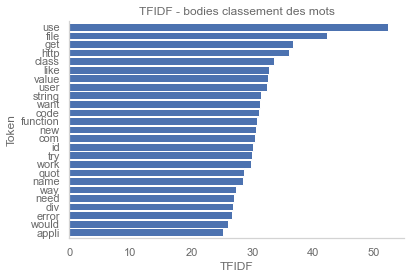

In [18]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies classement des mots')

### Titles

In [19]:
%%time
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 86.6 ms, sys: 14.7 ms, total: 101 ms
Wall time: 65.6 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - titles - classement des mots')]

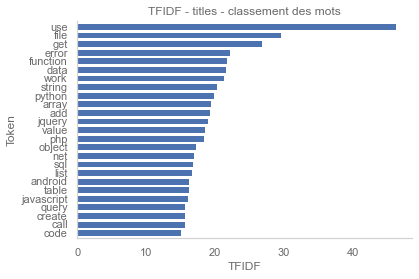

In [20]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - titles - classement des mots')

In [21]:
dfTFIDF_titles.shape,dfTFIDF_bodies.shape

((2000, 3140), (2000, 14092))

### Pondere

TF-IDF (Pondéré) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)  
par ex. avec alpha=0.8

In [22]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

In [23]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2363 entries, colspan to extremely
dtypes: float64(2363)
memory usage: 36.1 MB


<AxesSubplot:>

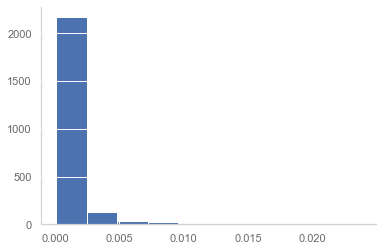

In [24]:
dfTFIDFCommon.mean(axis=0).hist()

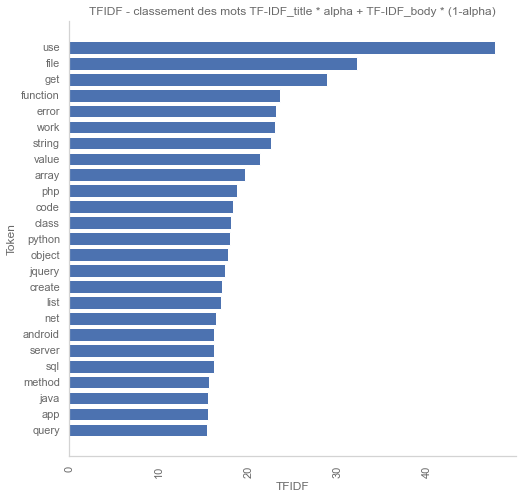

In [25]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [26]:
X=dfTFIDFCommon.values
X.shape

(2000, 2363)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


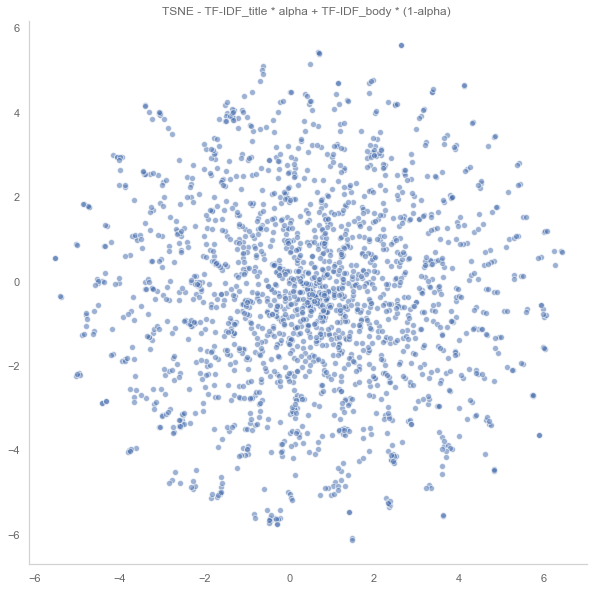

In [27]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) ')
plt.show()

### Bodies+titles

In [28]:
%%time
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 384 ms, sys: 77.9 ms, total: 462 ms
Wall time: 444 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies_titles - classement des mots')]

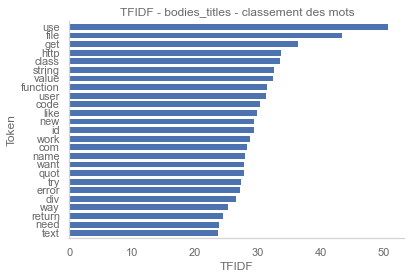

In [29]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies_titles - classement des mots')

Le calcul de TFIDF sur les corps et titres de message concaténés donne le même classement que pour le TFIDF sur les corps seuls.  
On preferera donc le TFIDF pondéré sur les titres et corps: TF-IDF_title * alpha + TF-IDF_body * (1-alpha).

In [30]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


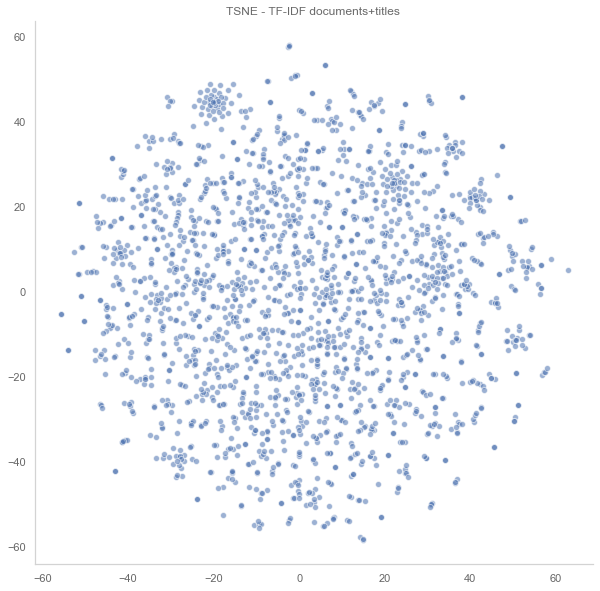

In [31]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF documents+titles ')
plt.show()

des regroupements semblent apparaitre sur la visualisation TSNE, voyons le score de silhouette/nombre de clusters obtenu par clustering K-Means

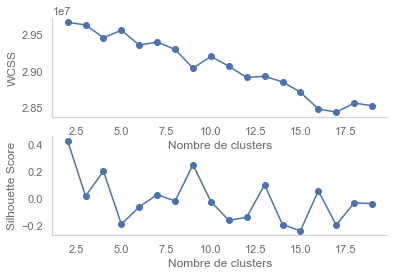

CPU times: user 9min 12s, sys: 11.9 s, total: 9min 24s
Wall time: 53.5 s


In [32]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Le score de silhouette <0.25 au dela de 2 clusters.  
Le clustering KMeans n'est pas concluant pour les titres et corps de messages concaténés.

## REDUCTION DIMENSIONNELLE - ACP

<AxesSubplot:>

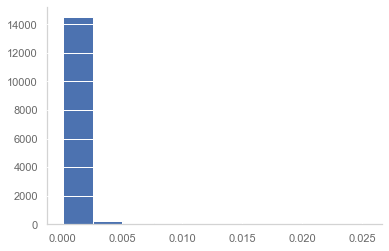

In [33]:
dfTFIDF_bodies_titles.mean(axis=0).hist()

La distribution des scores TFIDF est concentrée entre les valeurs 0 et 0.0025

In [34]:
# on ne garde que les token avec des TDFIDF significatif (>0.5)
df=dfTFIDFCommon[(dfTFIDFCommon.fillna(0))>0.01].fillna(0)
df.describe()

,colspan,destroys,initialization,unit,well,window,elem,interpret,valuechangelistener,late,regard,reverse,wsdl,current,nstimer,ascend,major,suggest,cookie,logic,suhosin,rpc,picturebox,coverage,relevant,generate,help,defaultbutton,orient,stub,linkbutton,map,along,resolution,cocoa,ii,rule,eclipselink,generic,behave,...,elastic,profit,autoresizing,galileo,identity,filenotfounderror,importerror,hashtag,body,sub,opengl,assistance,destroy,dilemma,technology,order,handler,happens,screen,collision,populates,define,material,complex,put,fqdn,paginate,geokit,ocx,static,gallery,prototype,intersect,need,ptr,work,csv,nullpointer,arduino,extremely
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.000264,0.000217,0.000521,0.001436,0.001402,0.005106,0.000236,0.000216,0.000216,0.000446,0.000529,0.000544,0.000319,0.001981,0.000188,0.000277,0.000246,0.000473,0.000669,0.000601,0.000273,0.000240,0.000509,0.000168,0.000298,0.003036,0.003635,0.000240,0.000225,0.000406,0.000204,0.003019,0.000323,0.000724,0.000845,0.001026,0.000483,0.000298,0.002139,0.000254,...,0.000238,0.000183,0.000265,0.000258,0.000883,0.000299,0.000339,0.000169,0.000803,0.000669,0.001153,0.000430,0.000335,0.000170,0.000661,0.003366,0.000341,0.000452,0.001911,0.000238,0.000256,0.003516,0.000711,0.000865,0.001783,0.000209,0.000282,0.000181,0.000359,0.001871,0.000409,0.000388,0.000190,0.004446,0.000264,0.010504,0.001652,0.000299,0.000246,0.000208
std,0.010672,0.009716,0.015124,0.019507,0.014829,0.033929,0.010275,0.008122,0.009670,0.010580,0.009031,0.013032,0.011226,0.023757,0.007583,0.011535,0.007834,0.007645,0.018125,0.012835,0.012212,0.009377,0.015809,0.006996,0.007885,0.029655,0.030010,0.010719,0.008825,0.011957,0.009133,0.031735,0.009026,0.016879,0.017865,0.020314,0.012402,0.012849,0.029183,0.009635,...,0.009750,0.007287,0.011205,0.011536,0.017259,0.012619,0.014113,0.007302,0.010112,0.009284,0.021241,0.013344,0.012312,0.007105,0.016901,0.032087,0.007229,0.009928,0.023178,0.010623,0.010145,0.032795,0.016353,0.017728,0.020655,0.009106,0.012042,0.008101,0.015418,0.022126,0.010986,0.013748,0.008485,0.028725,0.010579,0.048183,0.024268,0.012401,0.009829,0.008364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [35]:
dataPCA=df
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2363 entries, colspan to extremely
dtypes: float64(2363)
memory usage: 36.1 MB


(None,
 Index(['colspan', 'destroys', 'initialization', 'unit', 'well', 'window',
        'elem', 'interpret', 'valuechangelistener', 'late',
        ...
        'gallery', 'prototype', 'intersect', 'need', 'ptr', 'work', 'csv',
        'nullpointer', 'arduino', 'extremely'],
       dtype='object', length=2363))

In [36]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [37]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2363)

In [38]:
n_comp=1700 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=1700)

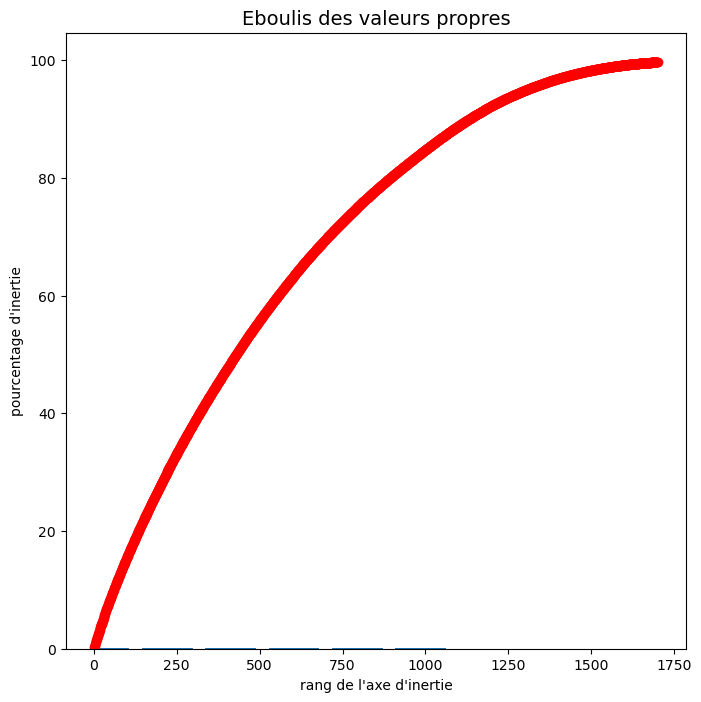

In [39]:
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [40]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [41]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 52.1 ms, sys: 11.6 ms, total: 63.6 ms
Wall time: 53.8 ms


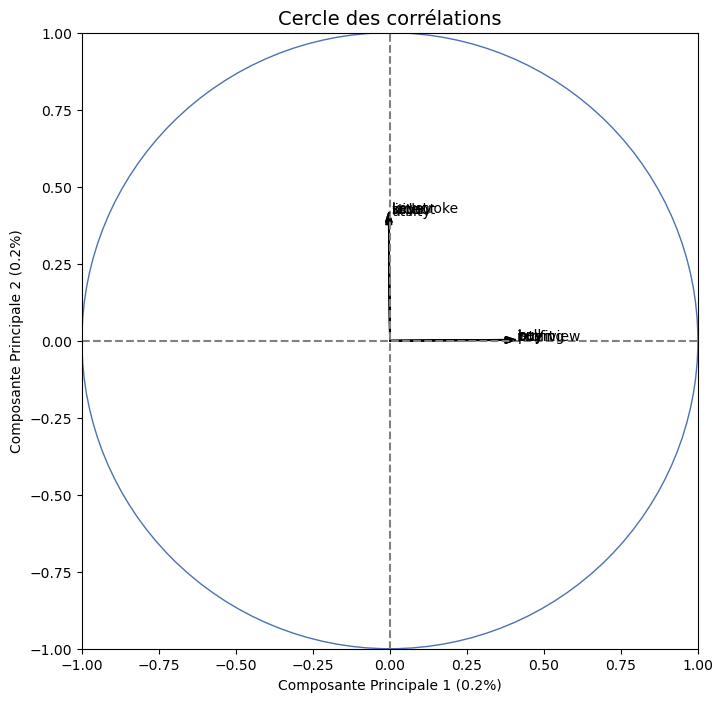

In [42]:
%%time
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.35:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.01,composantesPrincipales[d2][i]),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [43]:
composantesPrincipales[d1]

array([ 0.00296617, -0.00039913, -0.00081552, ..., -0.00027529,
       -0.0003558 , -0.00066281])

In [44]:
X.shape,composantesPrincipales[d1].shape,composantesPrincipales[d2].shape

((2000, 2363), (2363,), (2363,))

In [45]:
composantesPrincipales

array([[ 2.96616706e-03, -3.99131333e-04, -8.15521443e-04, ...,
        -2.75286483e-04, -3.55797142e-04, -6.62808255e-04],
       [-1.17379652e-03, -4.67179106e-04, -1.25867069e-03, ...,
        -4.99387896e-04, -1.14967488e-03, -1.19924603e-03],
       [-7.04513253e-04,  3.29962561e-02, -1.84299628e-03, ...,
         6.93258545e-05, -1.31732198e-03, -1.89445535e-03],
       ...,
       [-2.72203563e-02, -7.78083380e-03,  2.02887163e-03, ...,
        -2.89715029e-03, -8.40368632e-03, -1.12133849e-03],
       [ 1.29521343e-02,  3.94220084e-03, -5.69297201e-04, ...,
        -7.68363968e-03, -1.49036083e-02, -1.88346538e-02],
       [-2.37557646e-02, -6.32355695e-03,  6.15645826e-03, ...,
         1.49525573e-03,  1.92264530e-03,  1.57812606e-02]])

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


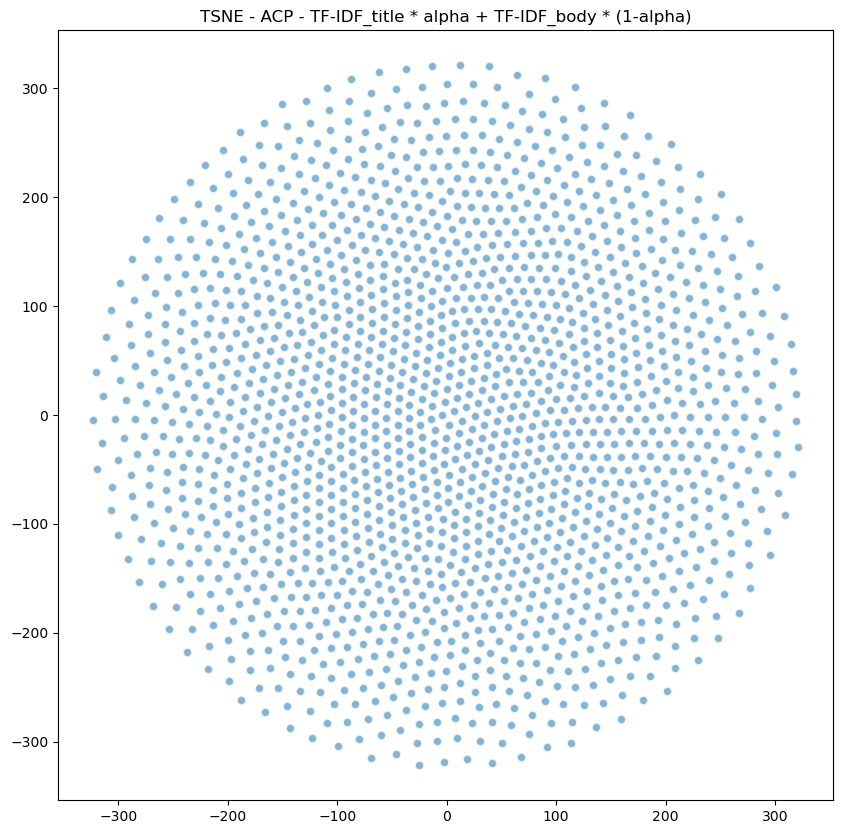

In [46]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

## CLUSTERING

In [47]:
X=df.values

### KMeans

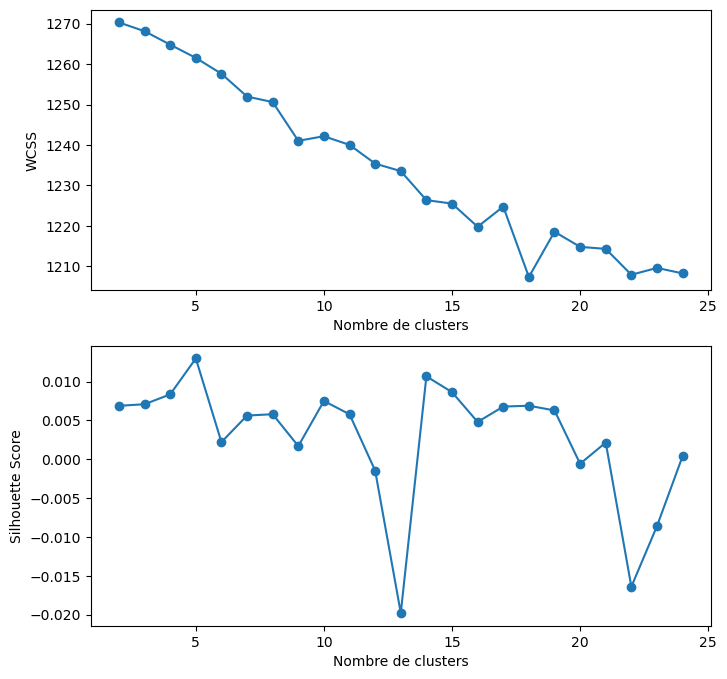

In [48]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,25):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,25), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,25), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Bi-grams

In [49]:
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (2,2))

In [50]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies - classement des mots')]

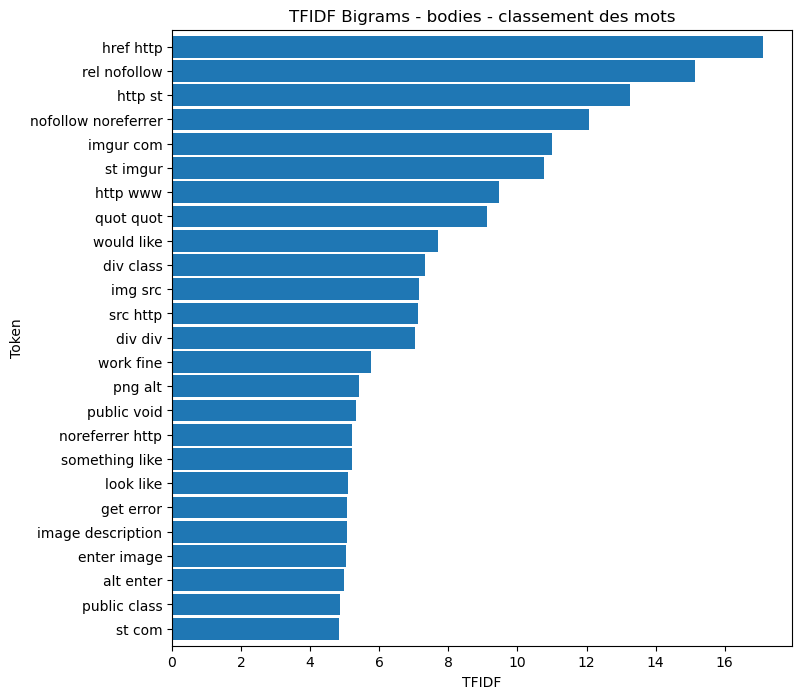

In [51]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies - classement des mots')

In [52]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - titles - classement des mots')]

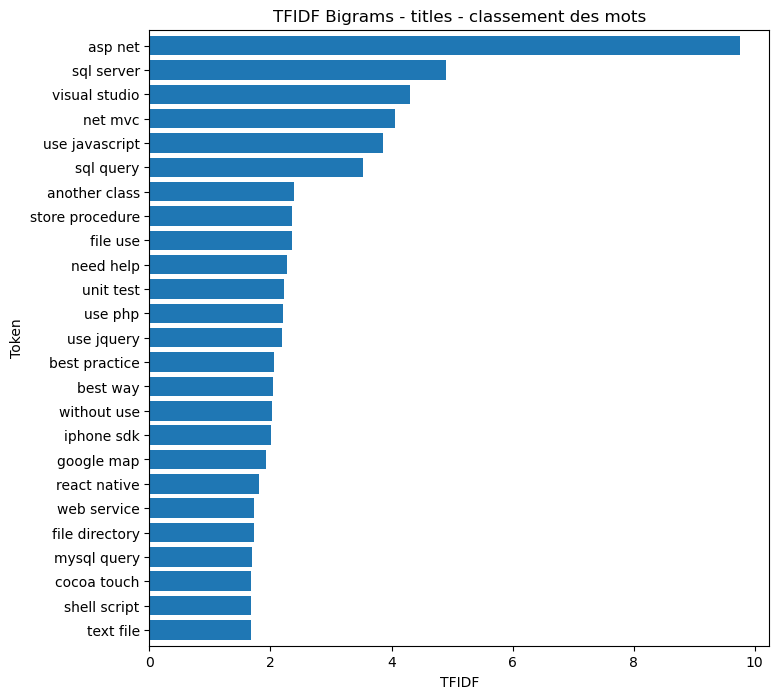

In [53]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - titles - classement des mots')

In [54]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies+titles - classement des mots')]

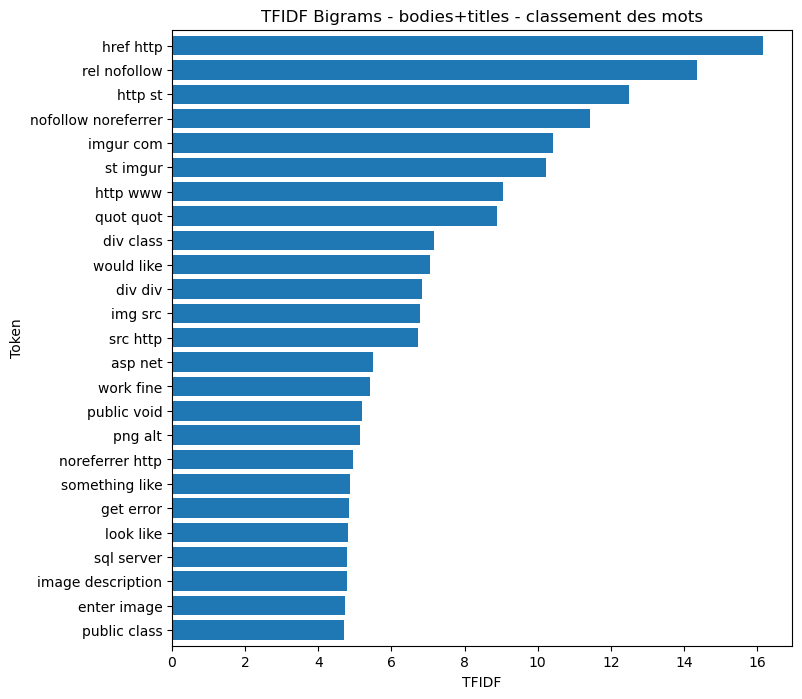

In [55]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies+titles - classement des mots')

In [56]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


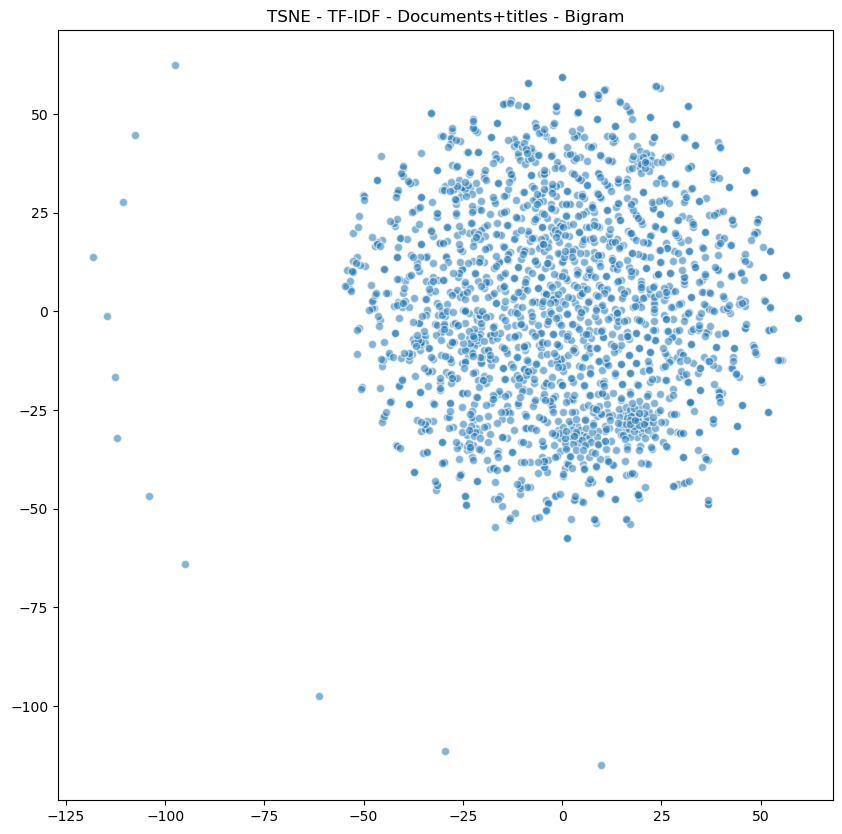

In [57]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Documents+titles - Bigram')
plt.show()

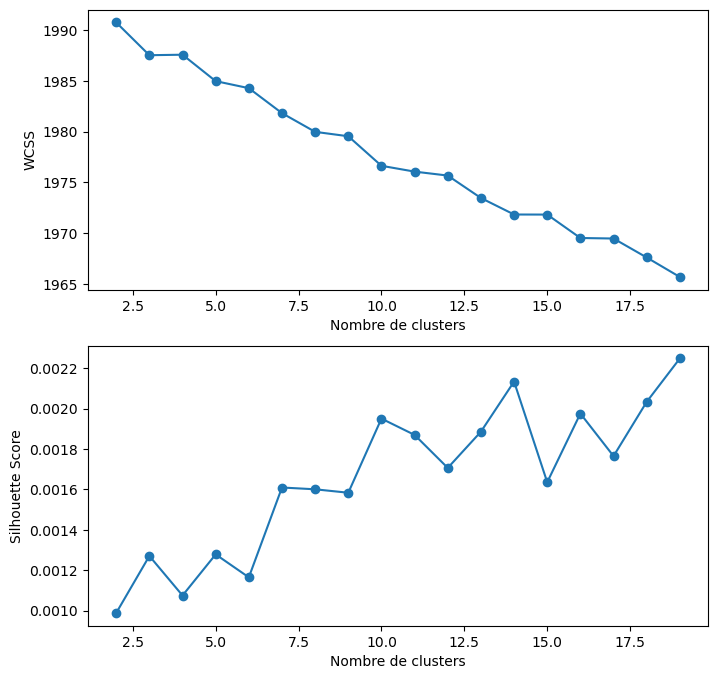

CPU times: user 2h 50min 19s, sys: 1min 44s, total: 2h 52min 4s
Wall time: 19min 47s


In [58]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
#centreReduit = preprocessing.StandardScaler().fit(X)
#XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [59]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

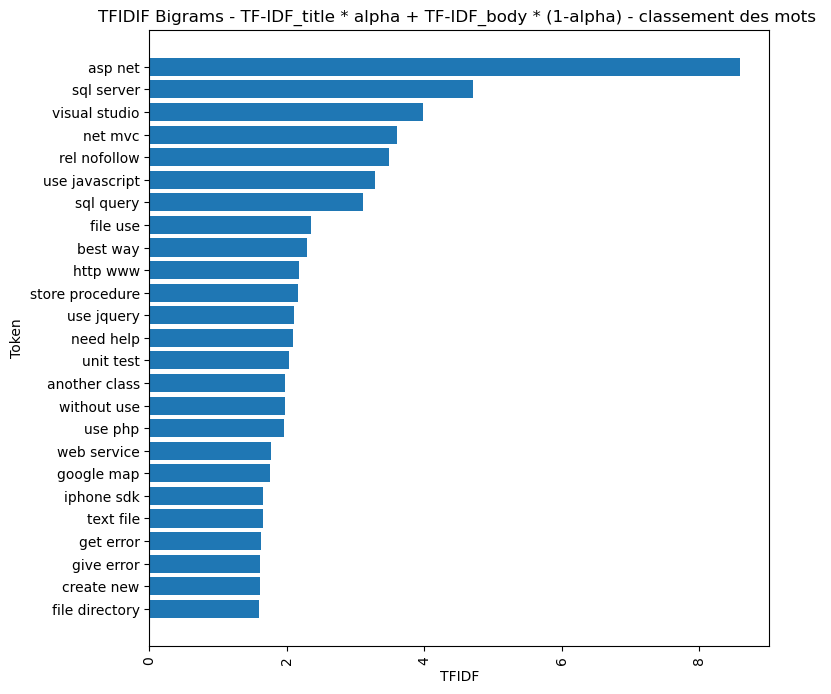

In [60]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDIF Bigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [61]:
X=dfTFIDFCommon.values

In [62]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

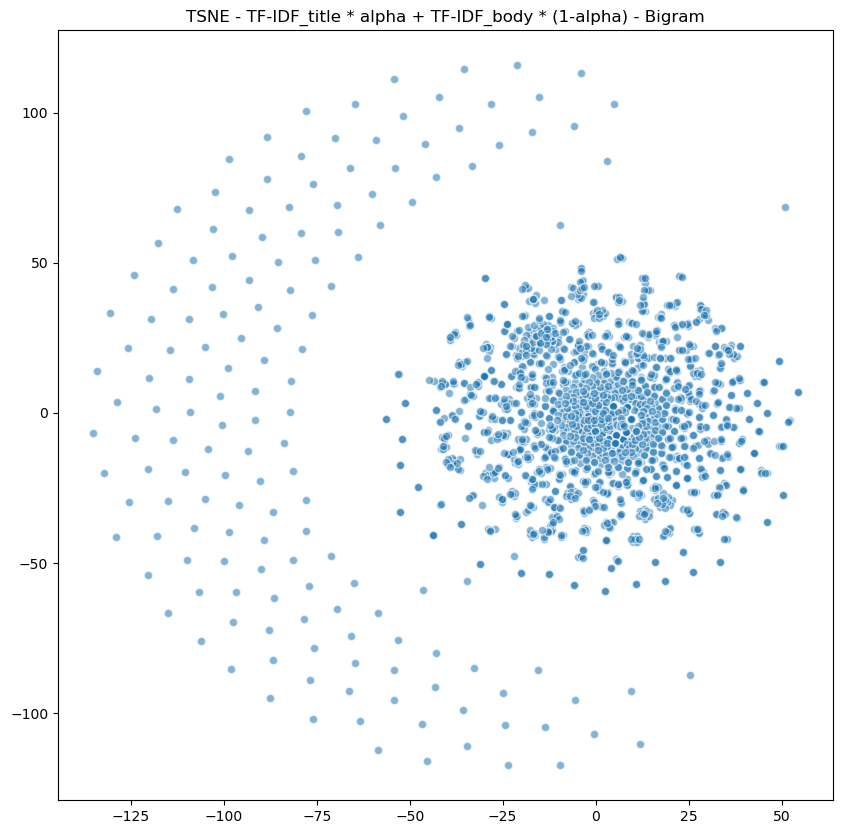

In [63]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Bigram')
plt.show()

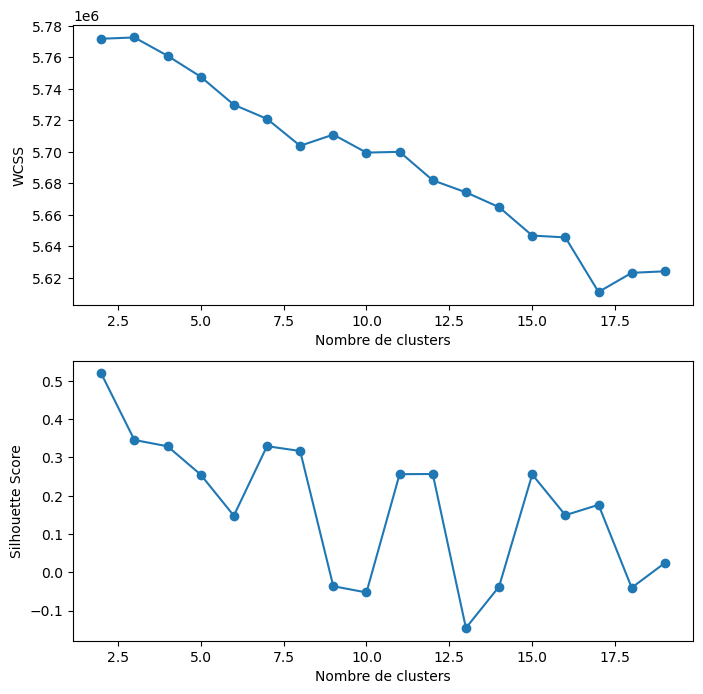

CPU times: user 2min 18s, sys: 7.03 s, total: 2min 25s
Wall time: 14.1 s


In [64]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tri-grams

In [65]:
%%time
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (3,3))



CPU times: user 4.04 ms, sys: 2.23 ms, total: 6.27 ms
Wall time: 6.06 ms


In [66]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - bodies - classement des mots')]

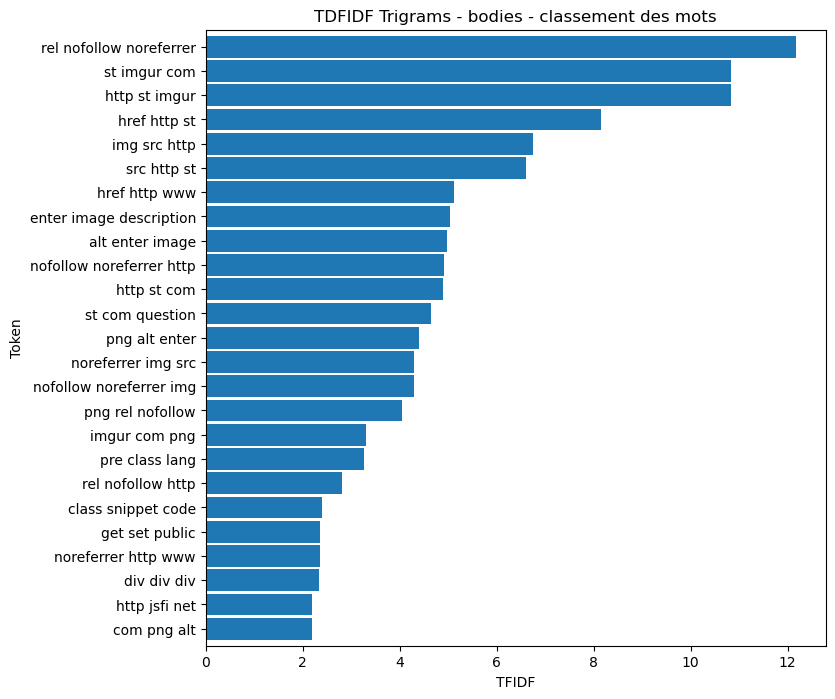

In [67]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - bodies - classement des mots')

In [68]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - classement des mots')]

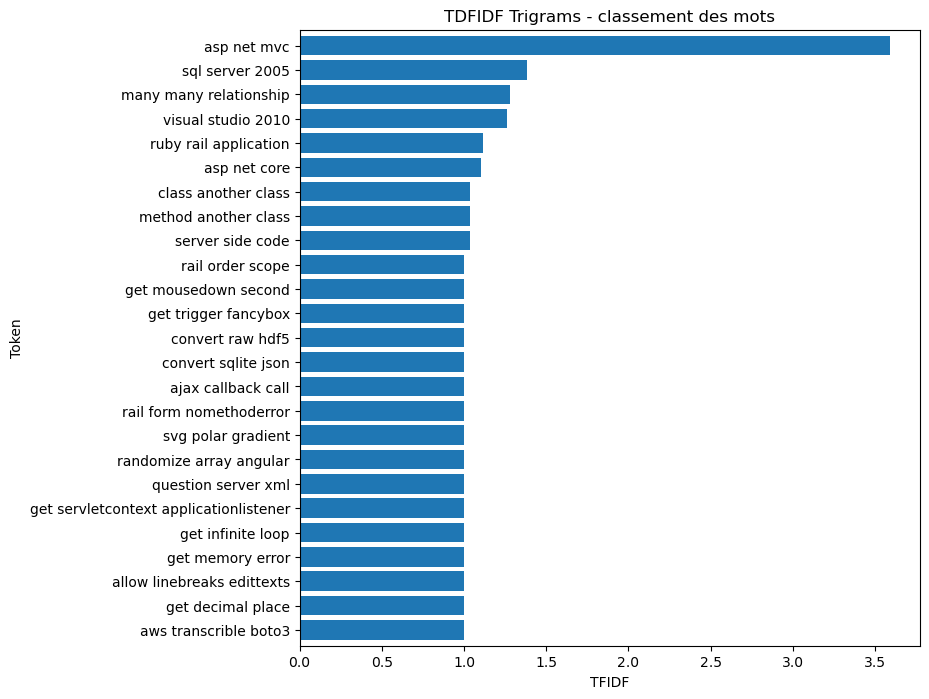

In [69]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - classement des mots')

In [70]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigram - bodies+titles - classement des mots')]

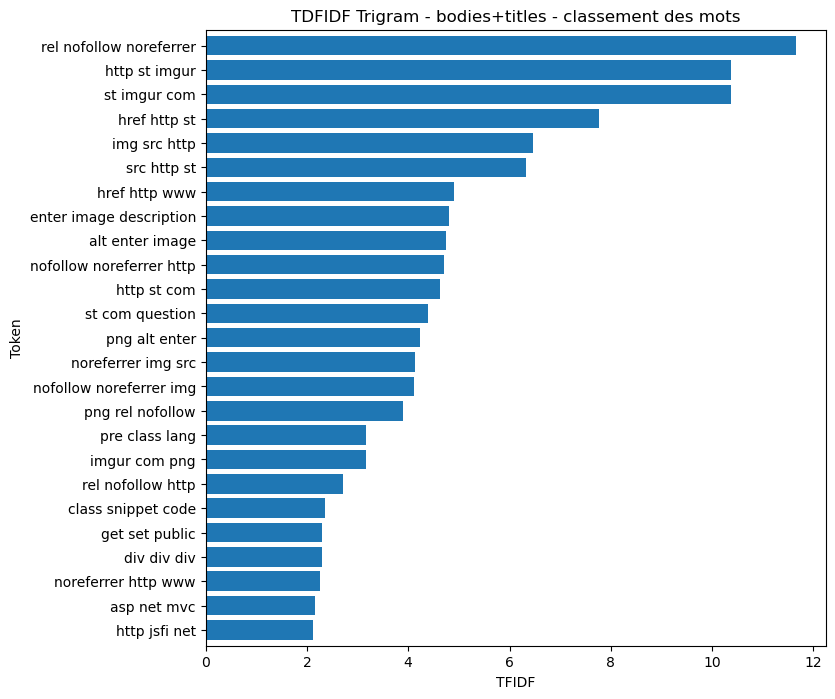

In [71]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigram - bodies+titles - classement des mots')

In [72]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


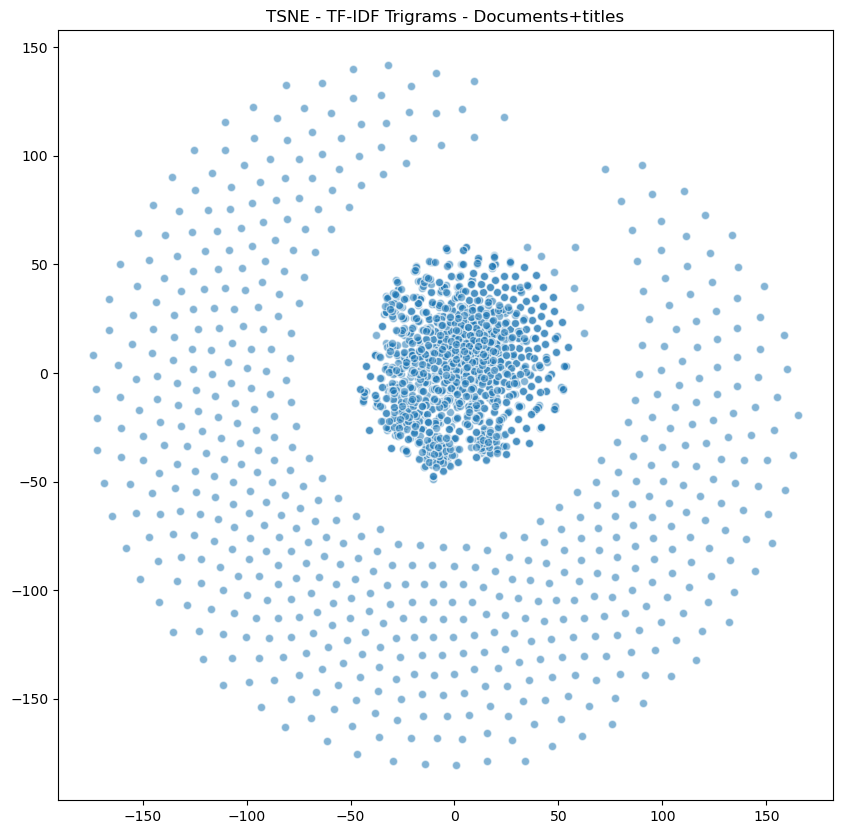

In [73]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF Trigrams - Documents+titles')
plt.show()

In [74]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

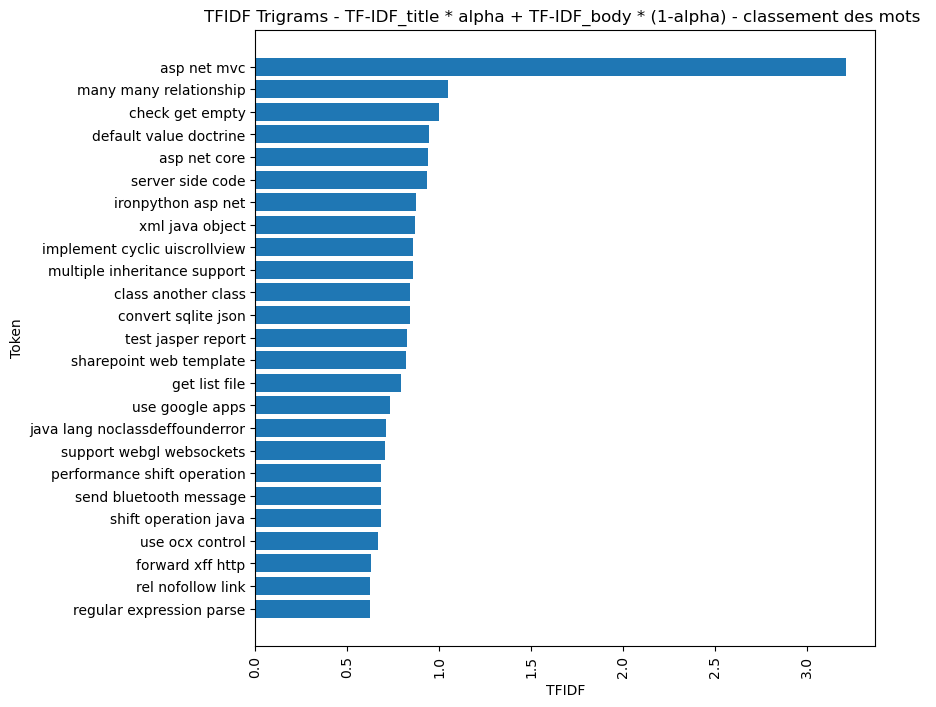

In [75]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF Trigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [76]:
X=dfTFIDFCommon

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


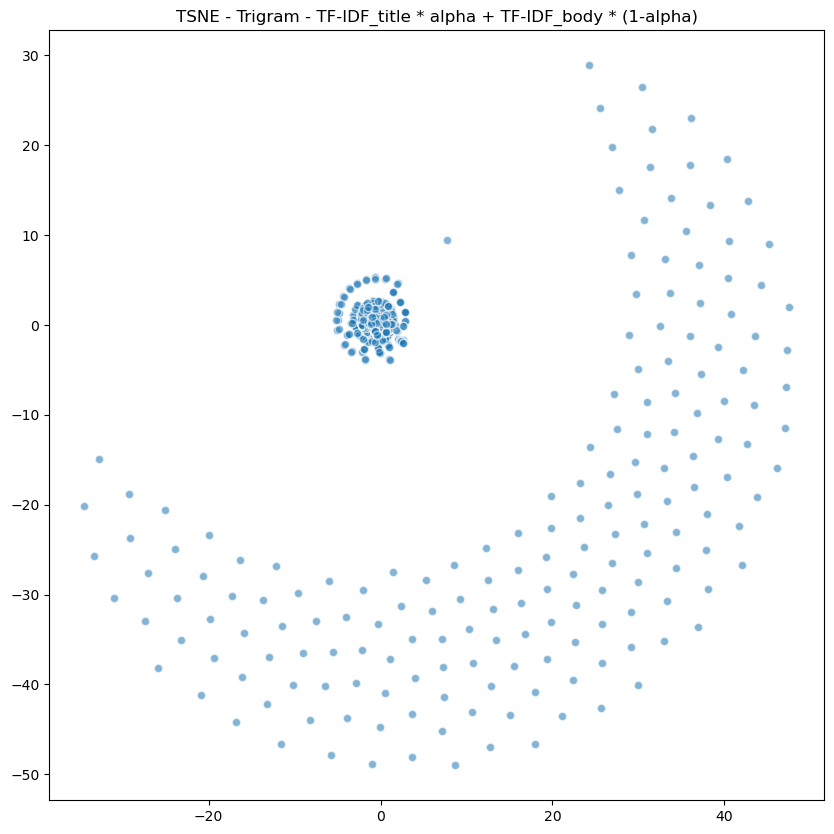

In [77]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - Trigram - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

# Exploration des tags

In [80]:
dfCleaned.sample(5)

,Title,Body,Tags,BodyLemmas,TitleLemmas,BodyTitleLemmas
24361,upgrade to ssl using streamsocket,"<p>i am working on winrt(windows8 release preview). i have a web application(in fact, a simpler xmpp client).</p>\n\n<p>i mainly use streamsocket class to connect the jabber server. it gives me a good start.but i met a problem when i try to upgrade the already connected socket to use ssl. </p>\n\n<p>i use <a href=""http://msdn.microsoft.com/query/dev11.query?appid=dev11idef1&amp;l=en-us&amp;k=k%28windows.networking.sockets.streamsocket.upgradetosslasync%29;k%28targetframeworkmoniker-.netcore,version%3dv4.5%29;k%28devlang-csharp%29&amp;rd=true"" rel=""nofollow"">streamsocket.upgradetosslasync</a> to implement it. it throws exception like this</p>\n\n<blockquote>\n <p>a method was called at an unexpected time. (exception from hresult:\n 0x8000000e)</p>\n</blockquote>\n\n<p>i have no idea why this happen. i have done all thing as the above link. i have created the socket connecting successfully. and i can receive some xml stanzas from jabber server.\nhere is a picture when it runs.![...",c# ssl xmpp windows-runtime microsoft-metro,"[work, winrt, window, release, preview, web, appli, simpler, xmpp, client, mainly, use, streamsocket, class, connect, server, give, good, start, met, problem, try, upgr, alre, connect, socket, use, ssl, use, href, http, msdn, microsoft, com, query, dev, query, appid, dev, amp, en, u, amp, networking, socket, streamsocket, upgr, netcore, version, csharp, amp, rd, true, rel, nofollow, streamsocket, upgr, implement, throw, exception, like, method, unexpected, time, exception, hresult, idea, happen, do, thing, link, create, socket, connect, su, receive, xml, stanza, server, picture, run, enter, image, description, see, picture, href, http, st, imgur, com, dofsc, jpg, rel, nofollow, new, click, uptossl, button, crash, ...]","[upgrade, ssl, use, streamsocket]","[work, winrt, window, release, preview, web, appli, simpler, xmpp, client, mainly, use, streamsocket, class, connect, server, give, good, start, met, problem, try, upgr, alre, connect, socket, use, ssl, use, href, http, msdn, microsoft, com, query, dev, query, appid, dev, amp, en, u, amp, networking, socket, streamsocket, upgr, netcore, version, csharp, amp, rd, true, rel, nofollow, streamsocket, upgr, implement, throw, exception, like, method, unexpected, time, exception, hresult, idea, happen, do, thing, link, create, socket, connect, su, receive, xml, stanza, server, picture, run, enter, image, description, see, picture, href, http, st, imgur, com, dofsc, jpg, rel, nofollow, new, click, uptossl, button, crash, ...]"
16358,what is the best approach for designing udp server?,"<p>let's suppose there is a server dealing with multiple clients.\nand there is worlds consist of 6 clients.</p>\n\n<p>i think there are 3 approach for designing this server</p>\n\n<ol>\n<li><p>one socket for entire receiving task, another socket for entire sending task.</p></li>\n<li><p>one socket for entire receiving task, allocate sending socket for each world associated with 6 clients.</p></li>\n<li><p>receiving socket for each world, sending socket for each world</p></li>\n</ol>\n\n<p>which is the best?\n( of course. there can be other approaches )</p>\n\n<p>sorry for my bad english :)</p>\n",linux sockets server udp,"[let, suppose, server, deal, multiple, client, world, consist, client, think, appro, design, server, one, socket, entire, receive, task, another, socket, entire, send, task, one, socket, entire, receive, task, allo, send, socket, world, associate, client, receive, socket, world, send, socket, world, best, course, appro, sorry, english]","[best, approach, design, udp, server]","[let, suppose, server, deal, multiple, client, world, consist, client, think, appro, design, server, one, socket, entire, receive, task, another, socket, entire, send, task, one, socket, entire, receive, task, allo, send, socket, world, associate, client, receive, socket, world, send, socket,

In [84]:
tags=dfCleaned['Tags'].map(''.join)
tags

611          c++  linux  network-programming  network-protocols  net-snmp 
46618              amazon-web-services  apache-spark  pyspark  amazon-emr 
19158                                                  html  vba  ms-word 
46378                                        java  visual-studio  interop 
27006                                            perl  distribution  cpan 
9115                             algorithm  graph  dijkstra  path-finding 
16372      node.js  actions-on-google  chatbot  dialogflow-es-fulfillment 
29974          asp.net  asp.net-ajax  cascadingdropdown  invalid-postback 
12469                               javascript  java  jquery  string  int 
41941                                                             laravel 
46695        database  design-patterns  language-agnostic  oop  migration 
32486                                         node.js  express  typeerror 
                                       ...                                
2941          environment

In [85]:
dfBowTags=bow(tags)
nBowTags=dfBowTags.to_numpy() # optimisation des calculs en passant par numpy

In [130]:
uniquerows=np.unique(nBowTags, axis=0)
uniquerows.shape,dfBowTags.shape

((1777, 1871), (2000, 1871))

In [90]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 690 entries, return single value to source weblogic server
dtypes: float64(690)
memory usage: 10.5 MB


In [91]:
X=dfTFIDFCommon.values
y=nBowTags

In [95]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 690), (600, 690), (1400, 1871), (600, 1871))

In [99]:
MNNaiveBayes = MultinomialNB().fit(X_train, y_train)
y_pred_train=MNNaiveBayes.predict(X_train)
y_pred_test=MNNaiveBayes.predict(X_test)

ValueError: y should be a 1d array, got an array of shape (1400, 1871) instead.

# LDA

In [95]:
# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(documents)
train_data

NameError: name 'tokenize' is not defined

In [ ]:
# Define the number of topics or components
num_components=20

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)